In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import time
import random
import torch
import gc
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from tqdm import tqdm
import gstools as gs
from gstools.random import MasterRNG

from svgdfwi.fwi import *
from svgdfwi.kernel import *
from svgdfwi.utils import *
from svgdfwi.annealing import *
from svgdfwi.svgd import *
from svgdfwi.plots import *
from svgdfwi.perturbations import *


from pylops.utils.metrics import snr

# set seed
np.random.seed(10)
random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Config file

In [2]:
from hydra import initialize, compose

with initialize(version_base=None, config_path="../config"):
    cfg = compose("config_example")

## FWI setup

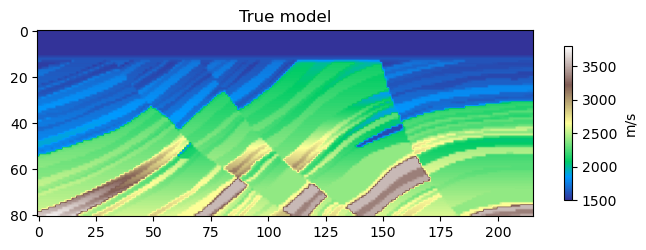

In [3]:
model_true = torch.from_numpy(np.load('../data/marmousi_portion.npy', allow_pickle=True).astype('float32')).to(device)
m_vmin, m_vmax = (cfg.params.m_vmin, cfg.params.m_vmax)

plt.figure(figsize=(8,4))
plt.imshow(model_true.detach().cpu(),cmap='terrain', vmin=m_vmin, vmax=m_vmax);
plt.colorbar(shrink=0.5, label='m/s', orientation='vertical')
plt.title('True model')
plt.show()

In [4]:
source_locations, receiver_locations, source_amplitudes, time_axis, xax, zax = setup_fwi_acquisition(cfg, device=device)

nz = cfg.params.nz
nx = cfg.params.nx
dx = cfg.params.dx

freq = cfg.params.peak_freq
nt = cfg.params.nt
dt = cfg.params.dt

In [6]:
data_obs = deepwave.scalar(
    model_true,
    dx, dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    pml_freq=freq,
)[-1]

# Generate noisy data
observed_data = add_noise(
    data_obs,
    noise_level=0.5,
)

# Compute data SNR
data_noisy_snr = snr(
    data_obs.detach().cpu().numpy(), observed_data.detach().cpu().numpy()
)

print(f"Noisy data SNR: {data_noisy_snr:.2f} dB")

Noisy data SNR: 15.87 dB


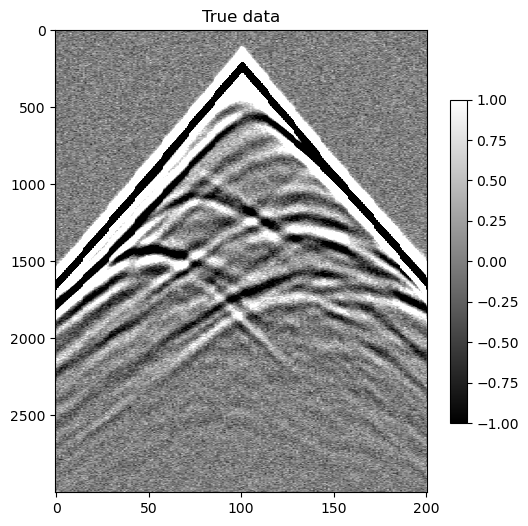

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(observed_data[2,:,:].T.detach().cpu().numpy(),cmap='grey',aspect='auto', vmin=-1, vmax=1)
plt.title('True data')
plt.colorbar(shrink=0.7)

## Initial model

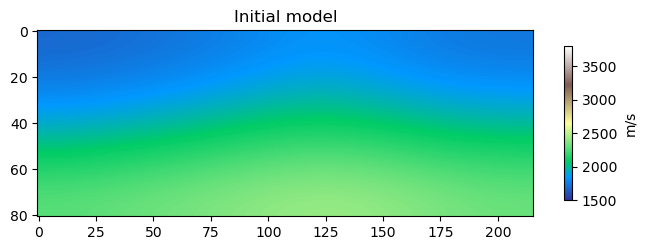

In [7]:
initial_model = torch.tensor(1/gaussian_filter(1/model_true.detach().cpu().numpy(),30)).to(device)

plt.figure(figsize=(8,4))
plt.imshow(initial_model.detach().cpu(),cmap='terrain', vmin=m_vmin, vmax=m_vmax);
plt.colorbar(shrink=0.5, label='m/s', orientation='vertical')
plt.title('Initial model')
plt.show()

In [8]:
# Create perturbations
grf, variances = generate_random_field_perturbations(cfg, distribution='uniform', 
                                                     min_var=10, max_var=2000, 
                                                     seed=20170590, len_scale=5, 
                                                     nu=2, device=device)


# Create set of initial particles
X_init = initial_model.clone()
X_init = X_init.reshape(1, -1).repeat(cfg.params.num_particles, 1).to(device)
X_init = X_init + grf
X_init.requires_grad = True

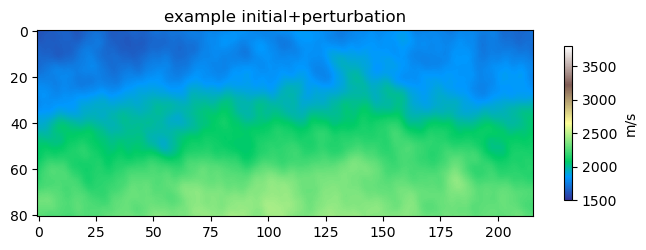

In [9]:
X = X_init.cpu().detach().numpy()

plt.figure(figsize=(8,4))
plt.imshow(X[0].reshape(cfg.params.nz, cfg.params.nx),cmap='terrain', vmin=m_vmin, vmax=m_vmax);
plt.colorbar(shrink=0.5, label='m/s', orientation='vertical')
plt.title('example initial+perturbation')
plt.show()

## SVGD 

In [10]:
loss_fn = torch.nn.MSELoss()
batch_size=cfg.params.batch_size
data_normalization=None

grad_func = lambda x: compute_gradient(
    x,
    source_locations,
    receiver_locations,
    nz,
    nx,
    dx,
    dt,
    freq,
    observed_data,
    source_amplitudes,
    loss_fn,
    batch_size,
    data_normalization,
    device,
)

In [11]:
optimizer = torch.optim.Adam([X_init],lr=cfg.params.learning_rate)
loss_fn = torch.nn.MSELoss()
scheduler = None
n_iterations=cfg.params.num_iterations

In [12]:
# when alpha = 1, it corresponds to vanilla SVGD

alpha = torch.ones(cfg.params.num_iterations)

# Annealed p=3 and 20% of the iter alpha=1 at the end
# alpha = alpha_tanh(250, p=3, device='cpu')

# plt.plot(alpha)

In [13]:
# Initialize kernel class
K = RBF()

  0%|          | 0/101 [00:00<?, ?it/s]

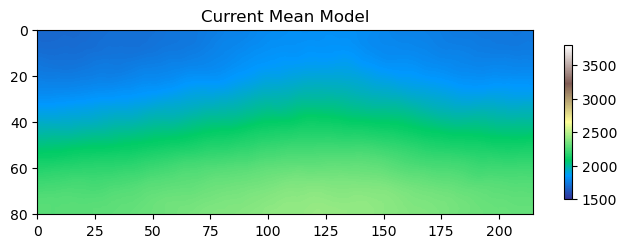

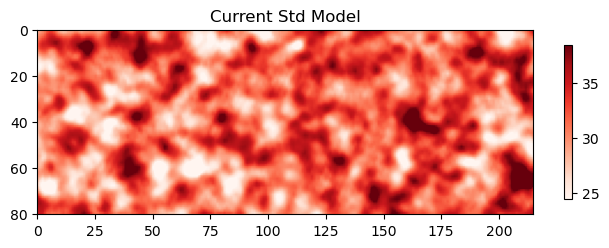

 10%|▉         | 10/101 [02:06<19:14, 12.69s/it, iter=9, loss=4.41e+3]

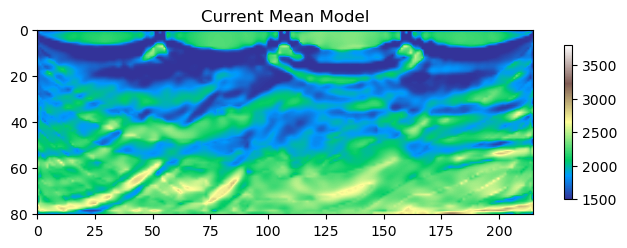

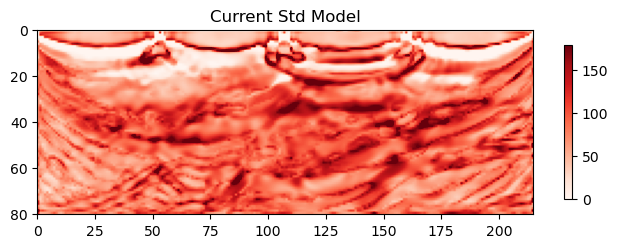

 20%|█▉        | 20/101 [04:23<18:41, 13.84s/it, iter=19, loss=3.41e+3]

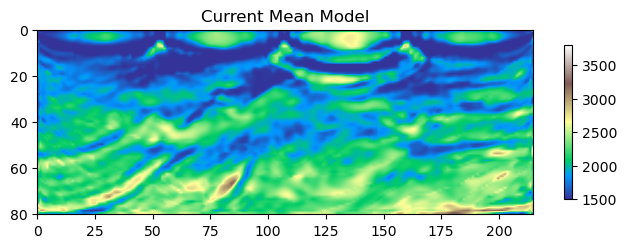

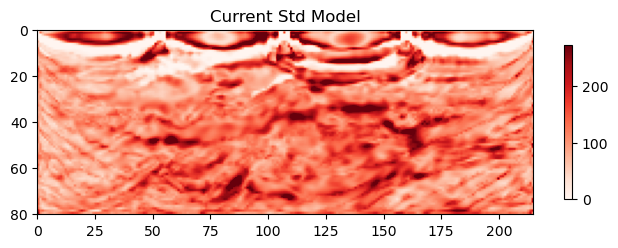

 30%|██▉       | 30/101 [06:31<12:57, 10.95s/it, iter=29, loss=2.54e+3]

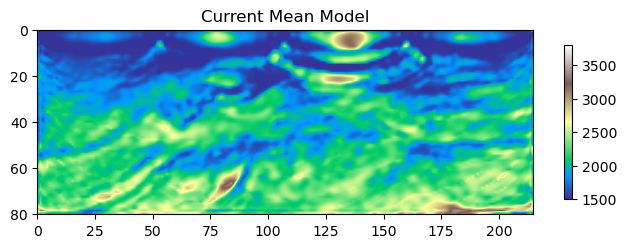

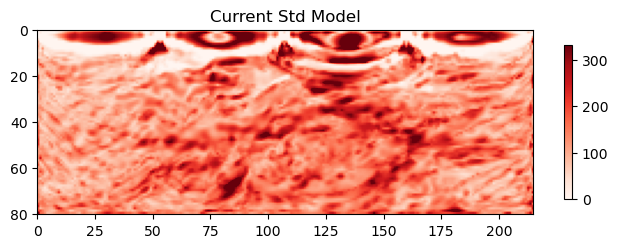

 40%|███▉      | 40/101 [08:59<16:06, 15.84s/it, iter=39, loss=1.96e+3]

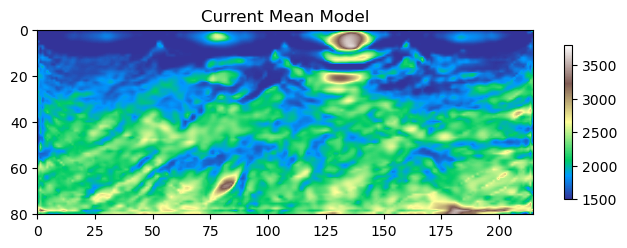

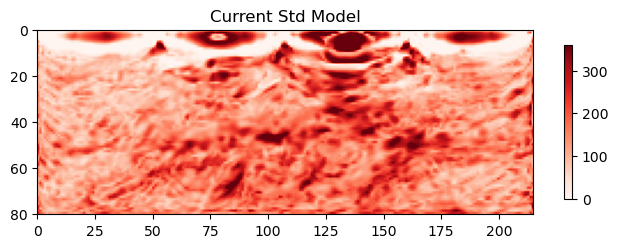

 50%|████▉     | 50/101 [11:45<14:03, 16.54s/it, iter=49, loss=1.56e+3]

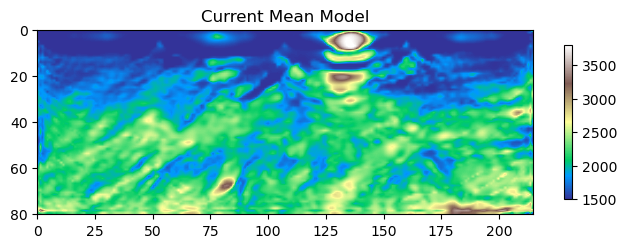

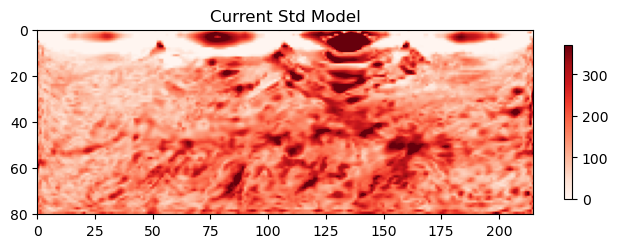

 59%|█████▉    | 60/101 [14:33<11:37, 17.01s/it, iter=59, loss=1.33e+3]

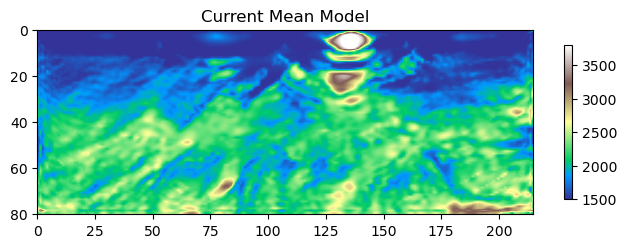

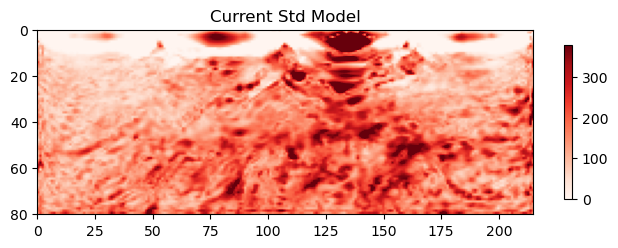

 69%|██████▉   | 70/101 [17:15<08:19, 16.11s/it, iter=69, loss=1.18e+3]

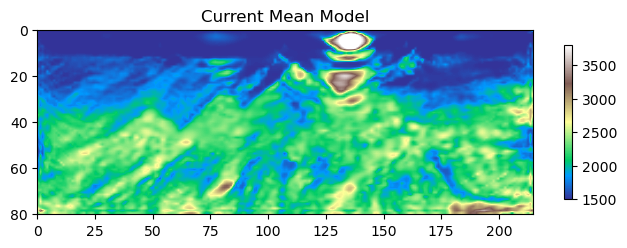

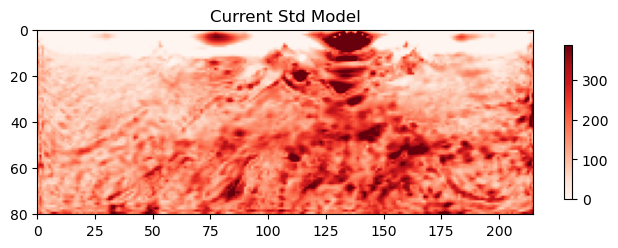

 79%|███████▉  | 80/101 [19:56<05:35, 15.97s/it, iter=79, loss=1.1e+3] 

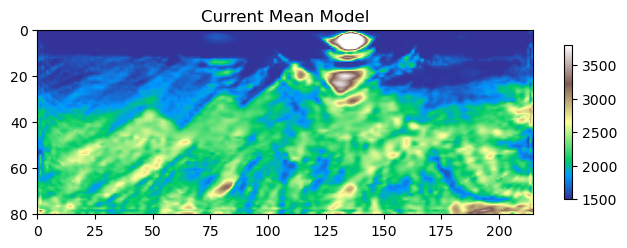

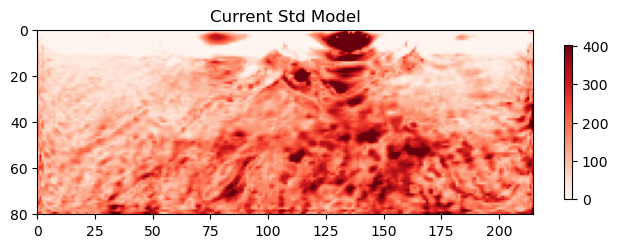

 89%|████████▉ | 90/101 [22:37<02:56, 16.07s/it, iter=89, loss=1.03e+3]

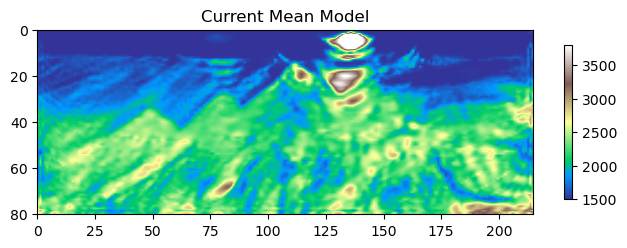

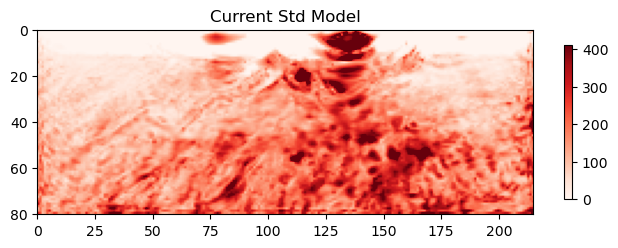

 99%|█████████▉| 100/101 [25:17<00:15, 15.82s/it, iter=99, loss=1e+3]  

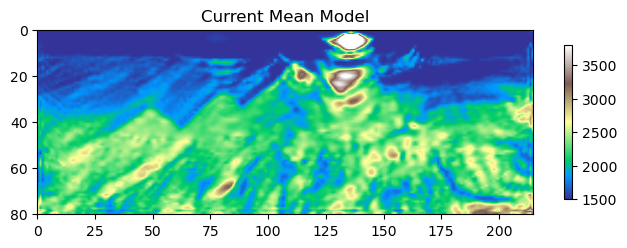

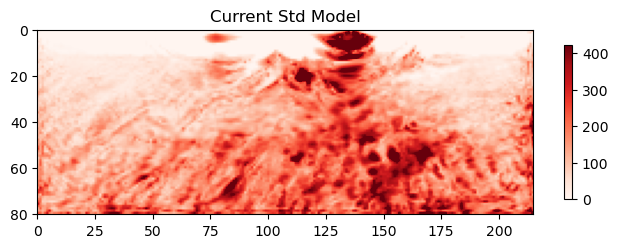

100%|██████████| 101/101 [25:33<00:00, 15.18s/it, iter=100, loss=983]


In [14]:
# Initialize the  kernel and SVGD_FWI class
svgd = SVGD(X_init, K, alpha, optimizer, scheduler, device='cuda')

# Dictionary to save all variables
results_svgd = {
    "epoch_loss": [],
    "updates": [],
    "updates_mean": [],
    "updates_std": [],
    "kernels": [],
    "sigmas": [],
}

# epochs = tqdm(range(cfg.params.num_iterations))
epochs = tqdm(range(cfg.params.num_iterations))

for iteration in epochs:
    
    # Convert X_init to CPU numpy array once and reuse
    X_init_np = X_init.detach().clone().cpu().numpy()
    

    # FWI model update and gradient computation
    running_loss=0
    running_loss, grad = compute_gradient_per_batch(X_init, grad_func)
    
    grad_collection = torch.zeros_like(X_init)
    for ig, sgrad in enumerate(grad):
        smooth_grad = sgrad.reshape(nz, nx)
        smooth_grad = torch.from_numpy(smooth_grad).to(device)
        grad_collection[ig] = smooth_grad.ravel()

    if iteration == 0:
        gmax = compute_max_gradient_per_batch(grad)
        gmax = torch.tensor(gmax).to(device=device)


    svgd.step(X_init, grad_collection, m_vmin, m_vmax, iteration, gmax, EMA=None)
    
        
    ## --------------------------------------
    ## Using exponential moving average to control the sigma 
    # if iteration == 0:
    #     svgd.step(X_init, grad_collection, m_vmin, m_vmax, iteration, gmax, EMA=None)

    ## Adding Exponential moving average to the sigma
    # EMA = [svgd.sigma, 0.4]
    # svgd.step(X_init, grad_collection, m_vmin, m_vmax, iteration, gmax, EMA)

    
    ## --------------------------------------
    ## Kernel assisted particle replacement
    # if iteration % 10 == 0:
    #     replaced_particles = replace_particles(kernel_matrix=svgd.K_XX.detach().cpu().numpy(), 
    #                               particle_data=X_init.detach().clone().cpu(), 
    #                               threshold=1e-1, percentage=80, 
    #                               device='cpu', kind='isolated')
    #     with torch.no_grad():
    #         X_init.data = torch.from_numpy(replaced_particles).to(device)

    
    # Collect results
    results_svgd["updates"].append(X_init_np.astype(np.float16))
    results_svgd["updates_mean"].append(X_init_np.mean(0).astype(np.float16))
    results_svgd["updates_std"].append(X_init_np.std(0).astype(np.float16))
    results_svgd["sigmas"].append(np.float16(svgd.sigma)) 
    results_svgd["epoch_loss"].append(np.float16(running_loss))
    results_svgd["kernels"].append(svgd.K_XX.detach().cpu().numpy().astype(np.float16))



    if torch.isnan(X_init).any():
        print("NaN detected in X_init")

    # Perform garbage collection less frequently
    if iteration % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

        plot_mean_std_models(results_svgd["updates_mean"], results_svgd["updates_std"], cfg, m_vmin, m_vmax, xax, zax)


    # Update tqdm postfix
    epochs.set_postfix(iter=iteration, loss=running_loss)


# #Save the dictionary
# save_dict_as_compressed_npz('test_results_svgd.npz', results_svgd)


Text(0.5, 1.0, 'Loss')

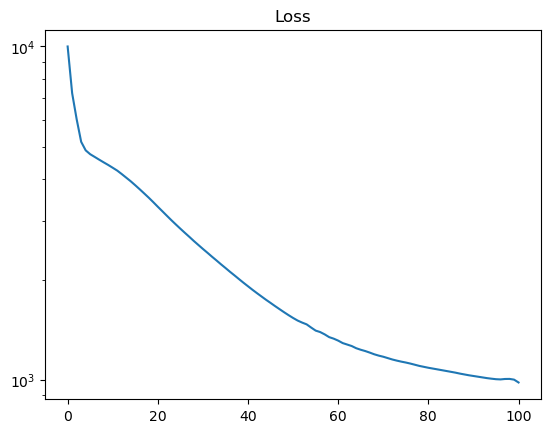

In [15]:
plt.semilogy(results_svgd["epoch_loss"])
plt.title('Loss')

Text(0.5, 1.0, 'bandwidth')

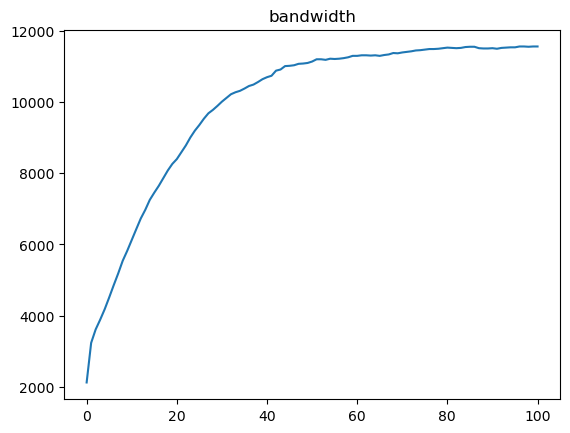

In [16]:
plt.plot(results_svgd["sigmas"])
plt.title('bandwidth')